In [148]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

In [149]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model_weights.h5'
model_name = 'bottleneck_model.h5'
data_dir = '../data'
nb_train_samples = 2800
epochs = 50
batch_size = 16

In [150]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    np.save('bottleneck_features_train.npy', bottleneck_features_train)


In [151]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))


    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=0.1)
    model.save_weights(top_model_weights_path)
    model.save(model_name)
    return model

In [153]:
save_bottleneck_features()

Found 2800 images belonging to 2 classes.


In [154]:
model = train_top_model()

Train on 2520 samples, validate on 280 samples
Epoch 1/50
2520/2520 [==============================] - 6s 2ms/step - loss: 0.7433 - acc: 0.7262 - val_loss: 1.2378 - val_acc: 0.4393
Epoch 2/50
2520/2520 [==============================] - 4s 2ms/step - loss: 0.4677 - acc: 0.7901 - val_loss: 0.1935 - val_acc: 0.9286
Epoch 3/50
2520/2520 [==============================] - 4s 2ms/step - loss: 0.4037 - acc: 0.8345 - val_loss: 2.0268 - val_acc: 0.3929
Epoch 4/50
2520/2520 [==============================] - 4s 2ms/step - loss: 0.3711 - acc: 0.8452 - val_loss: 0.4440 - val_acc: 0.7714
Epoch 5/50
2520/2520 [==============================] - 4s 2ms/step - loss: 0.3497 - acc: 0.8599 - val_loss: 0.6670 - val_acc: 0.7214
Epoch 6/50
2520/2520 [==============================] - 4s 2ms/step - loss: 0.3058 - acc: 0.8817 - val_loss: 0.2709 - val_acc: 0.9000
Epoch 7/50
2520/2520 [==============================] - 4s 2ms/step - loss: 0.2830 - acc: 0.8861 - val_loss: 0.6315 - val_acc: 0.7536
Epoch 8/50
2520

In [155]:
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img

base_model = VGG16(weights='imagenet', include_top=False)
print("base model loaded")

model = load_model(model_name)
model.load_weights(top_model_weights_path)

def shape_img(img):
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x = x / 255.
    return x

def build_feature_img(model, img):
    return model.predict(shape_img(img))

def make_prediction(base_model, model, img):
    feature_img = build_feature_img(base_model, img)
    return model.predict_classes(feature_img), model.predict_proba(feature_img)

def predict(img):
    prediction, prob = make_prediction(base_model, model, img)
    return ['hotdog', 'not hotdog'][prediction.item(0)], prob
    

base model loaded


('hotdog', array([[  5.06649268e-14]], dtype=float32))


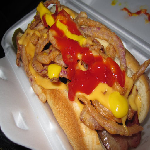

('hotdog', array([[  1.46716850e-09]], dtype=float32))


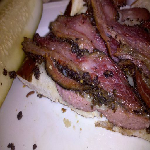

('not hotdog', array([[ 1.]], dtype=float32))


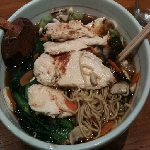

('not hotdog', array([[ 0.99916077]], dtype=float32))


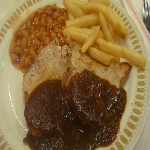

In [158]:
hotdog_img = load_img('../test/hotdog/2417.jpg', False, target_size=(img_width, img_height))
hotdog_img2 = load_img('../data/hotdog/30292.jpg', False, target_size=(img_width, img_height))
not_hotdog_img = load_img('../test/not_hotdog/9497.jpg', False, target_size=(img_width, img_height))
not_hotdog_img2 = load_img('../data/not_hotdog/963022.jpg', False, target_size=(img_width, img_height))

print(predict(hotdog_img))
display(hotdog_img)
print(predict(hotdog_img2))
display(hotdog_img2)
print(predict(not_hotdog_img))
display(not_hotdog_img)
print(predict(not_hotdog_img2))
display(not_hotdog_img2)

('hotdog', array([[ 0.]], dtype=float32))


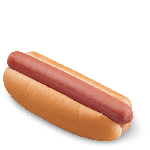

In [159]:
hotdog_img3 = load_img('../test/hotdog/1.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img3))
display(hotdog_img3)

('hotdog', array([[ 0.]], dtype=float32))


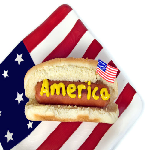

In [160]:
hotdog_img4 = load_img('../test/hotdog/2.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img4))
display(hotdog_img4)

('hotdog', array([[  2.21489596e-35]], dtype=float32))


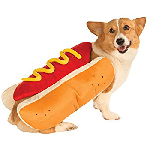

In [161]:
hotdog_img5 = load_img('../test/hotdog/3.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img5))
display(hotdog_img5)

('hotdog', array([[ 0.00185574]], dtype=float32))


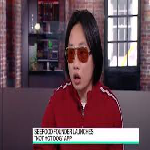

In [162]:
hotdog_img6 = load_img('../test/not_hotdog/1.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img6))
display(hotdog_img6)

('hotdog', array([[  5.25263476e-22]], dtype=float32))


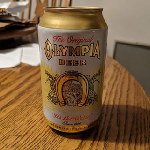

In [163]:
hotdog_img7 = load_img('../test/not_hotdog/2.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img7))
display(hotdog_img7)

('hotdog', array([[ 0.]], dtype=float32))


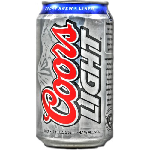

In [164]:
hotdog_img8 = load_img('../test/not_hotdog/3.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img8))
display(hotdog_img8)

('not hotdog', array([[ 0.57601583]], dtype=float32))


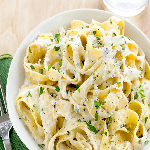

In [166]:
hotdog_img9 = load_img('../test/not_hotdog/4.jpg', False, target_size=(img_width, img_height))
print(predict(hotdog_img9))
display(hotdog_img9)